# Your crappy Jupyter code

> "a diamond in the rough"

This notebook is a made-up example of some code you might throw together while exploring your data. We're going to go through some next steps you'd take to make the code more robust if you wanted to reuse it.

## What does this notebook do?

* load the California housing price dataset using `pandas`
* do a bit of preprocessing
* use `scikit-learn` to:
  * do a train/test split on the data
  * train a random forest regressor
  * make predictions on the test set
  * build embeddings for a similarity plot on the test set
* use `matplotlib` to visualize the embeddings, and save out the figure

## What would our cleaned-up code do?

* input an arbitrary CSV file and any parameters we want to change
* run everything above in one step
* be packaged with tools to test whether everything's working and diagnose problems
* prevent your colleagues from silently judging you for having folders full of copies of the same jupyter notebook all with tiny changes in them. don't be basic.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble, sklearn.manifold, sklearn.datasets, sklearn.model_selection

%matplotlib inline
from IPython.core.pylabtools import figsize

In [7]:
df = pd.read_csv("california_housing_dataset.csv")

In [8]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## preprocessing

The latitude and longitude columns probably don't make much sense for any analysis we'd be doing. Let's drop those columns out.

In [9]:
for c in ["Latitude", "Longitude", "lat", "lon", "latitude", "longitude", "Lat", "Lon"]:
    if c in df.columns:
        print(f"removing column {c}")
        df = df.drop(c, 1)

removing column Latitude
removing column Longitude


In [10]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


## prepare data for supervised learning

* break out the covariates and target variable
* do a train/test split

In [88]:
target_col = "price"
assert target_col in df.columns, "noooo i cant find the dependent variable"


Y = df[target_col].values
X = df[[c for c in df.columns if c != target_col]].values

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1)

# check that the shapes match up
print("train inputs shape:", X_train.shape)
print("train outputs shape:", Y_train.shape)
print("test inputs shape:", X_test.shape)
print("test outputs shape:", Y_test.shape)

train inputs shape: (18576, 6)
train outputs shape: (18576,)
test inputs shape: (2064, 6)
test outputs shape: (2064,)


## train the random forest model

nothing fancy here

In [13]:
model = sklearn.ensemble.RandomForestRegressor(n_estimators=100)

In [14]:
%%time
model = model.fit(X_train, Y_train)

CPU times: user 9.29 s, sys: 78.8 ms, total: 9.37 s
Wall time: 9.43 s


## compute residuals

Measure how far off we are on the test set- we'll use this to flag the high-error cases in our visualization

In [15]:
y_hat = model.predict(X_test)

In [17]:
residual = y_hat - Y_test

## find similarities

Random forest models aggregate predictions from a bunch of tree models. Sometimes we can exploit them to gain some insight into our data by looking at how pairs of data points wound up in the same leaf node of a tree (meaning that that tree thought they were similar). 

If we represent our test data this way and the high-error cases cluster together, it could mean that there are some latent categories of data points that are harder to solve.

First, initialize a similarity matrix to count how many times each pair of data points winds up in a leaf node together:

In [19]:
N = len(Y_test)
similarity_matrix = np.zeros((N,N))

Now go through every tree in the forest and every pair of data points and increment the similarity matrix whenever they're in the same node:

In [23]:
%%time
# for each tree
for e in model.estimators_:
    # the tree.apply() function outputs the index of the leaf node
    leaf_ids = e.tree_.apply(X_test.astype(np.float32))
    # iterate through every pair of test points i and j
    for i in range(N):
        for j in range(i):
            # if i and j are in the same leaf node, increment the matrix
            if leaf_ids[i] == leaf_ids[j]:
                similarity_matrix[i,j] += 1
                similarity_matrix[j,i] += 1

CPU times: user 1min 40s, sys: 152 ms, total: 1min 40s
Wall time: 1min 40s


The plan is to turn those pairwise similarities into a scatter plot. Manifold learning tools like Isomap and T-SNE can do this, but they need pairwise distances, not similarities.

So we'll subtract the similarities from their largest value to get something like distances. I also found log-transforming them to help.

In [66]:
distance_matrix = np.log(similarity_matrix+1).max() - np.log(similarity_matrix+1)

In [67]:
distance_matrix.ravel().shape

(4260096,)

Then find some embeddings with T-SNE:

In [69]:
%%time
tsne = sklearn.manifold.TSNE(metric="precomputed")
embeddings = tsne.fit_transform(distance_matrix)

/Users/joe/anaconda3/envs/tda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


CPU times: user 1min 14s, sys: 1.64 s, total: 1min 16s
Wall time: 20.2 s


In [70]:
embeddings.shape

(2064, 2)

All that's left now is to visualize results and save the plot out. We'll set an arbitrary threshold of 1 for how large the magnitude of the residual can be before we call it "high error".

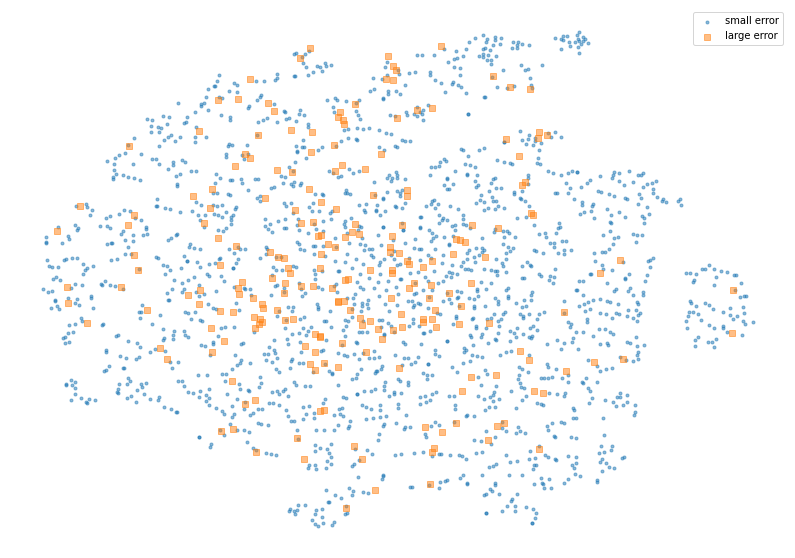

In [85]:
high_error = np.abs(resid) > 1
fig, ax = plt.subplots()
ax.scatter(embeddings[~high_error,0], embeddings[~high_error,1], alpha=alpha, marker=".",
           label="small error")
ax.scatter(embeddings[high_error,0], embeddings[high_error,1], alpha=alpha, marker="s",
           label="large error")
ax.legend(loc="upper right")
ax.axis(False);

In [87]:
fig.savefig("output.png")